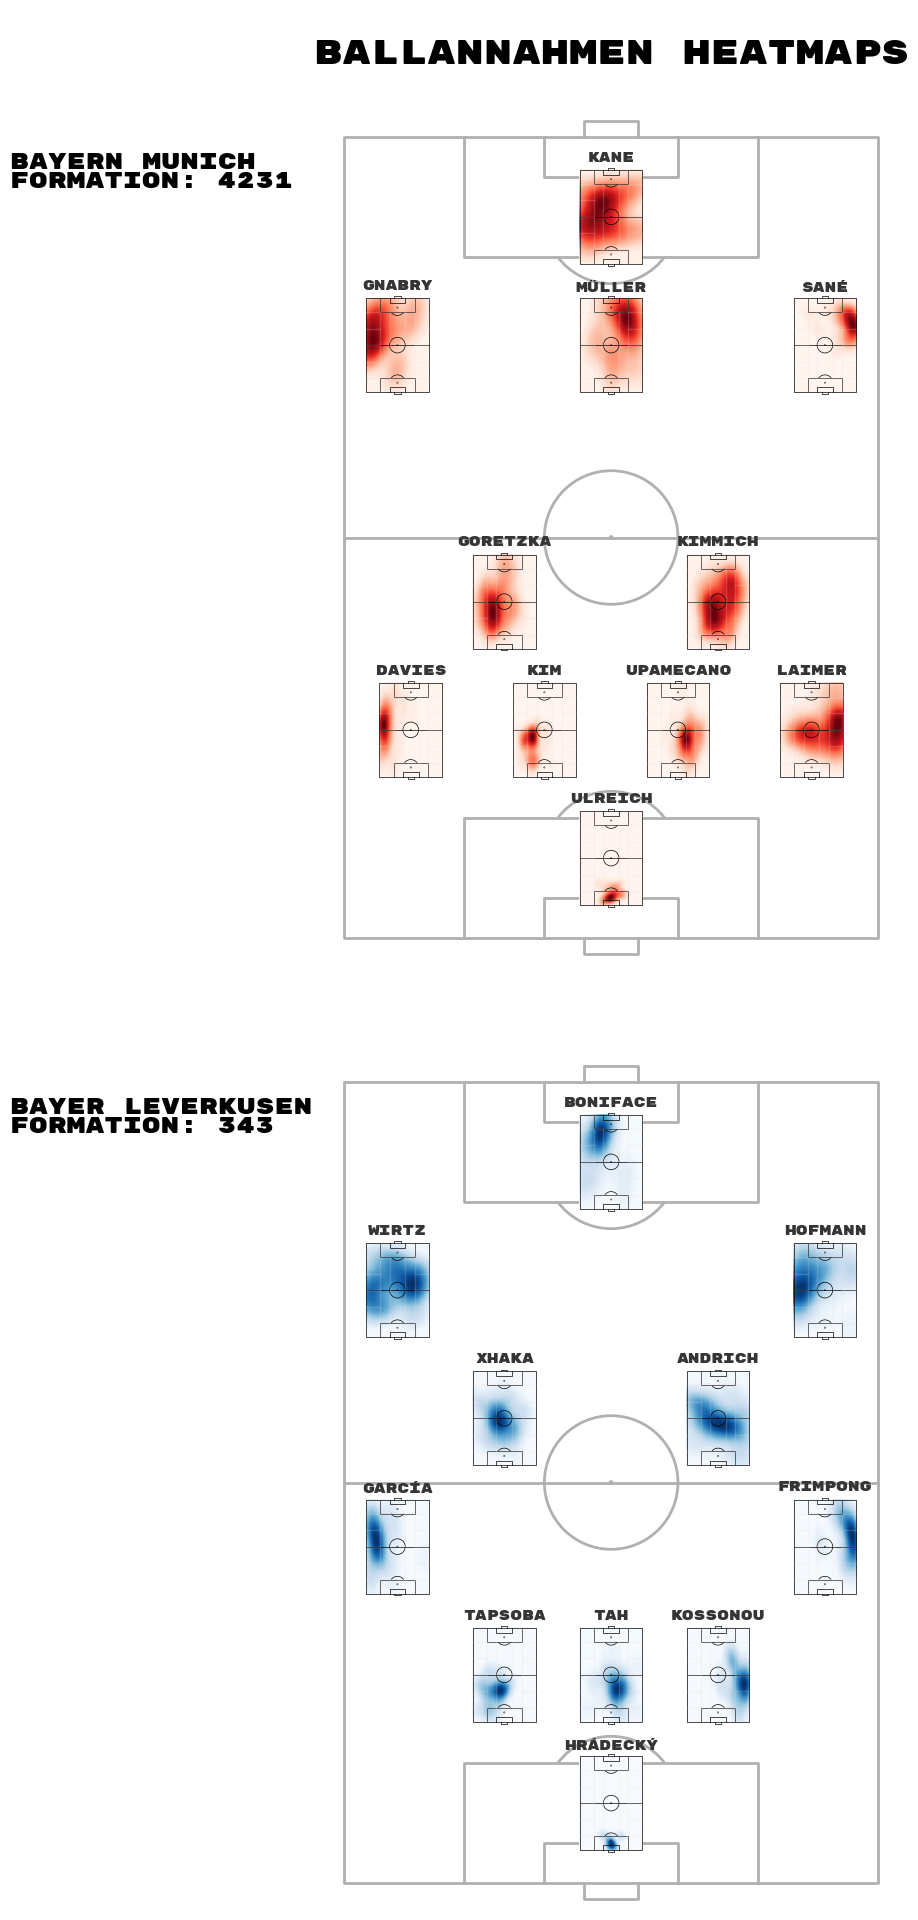

In [1]:
from mplsoccer import VerticalPitch, FontManager
import matplotlib.pyplot as plt
import pandas as pd
from statsbombpy import sb

# Font für Titel
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/RubikMonoOne-Regular.ttf')

# Match-Daten laden
match_id = 3895074
events = sb.events(match_id=match_id)

# Teams und Starting XI holen
starting_xi_events = events[events['type'] == 'Starting XI']
team_ids = starting_xi_events['team_id'].tolist()
team_names = starting_xi_events['team'].tolist()
team_colors = ['Reds', 'Blues']  # Heatmap-Farben je Team


pitch = VerticalPitch(goal_type='box')

fig, axs = pitch.grid(
    nrows=2,            
    ncols=1,            
    endnote_height=0,
    title_height=0.04,
    figheight=20,
    grid_width=0.9,
    grid_height=0.9,
    axis=False
)
axs = axs['pitch']  

# Durch beide Teams loopen
for idx, (team_id, team_name, color, ax) in enumerate(zip(team_ids, team_names, team_colors, axs)):
    # Starting XI Event
    tactics = starting_xi_events[starting_xi_events['team_id'] == team_id]['tactics'].iloc[0]
    lineup = tactics['lineup']
    formation = tactics['formation']
    formation_str = str(formation)

    # DataFrame mit Spielern
    df = pd.DataFrame([{
        'player_id': p['player']['id'],
        'player_name': p['player']['name'],
        'position_id': p['position']['id'],
        'position_name': p['position']['name'],
        'jersey_number': p['jersey_number']
    } for p in lineup])

    # Nur Nachname ausgeben
    df["player_name"] = df["player_name"].apply(lambda x: str(x).split()[-1])

    # Ball Receipt Events für dieses Team
    event = events.loc[
        (events['type'] == 'Ball Receipt*') &
        (events['ball_receipt_outcome'].isnull()) &
        (events['player_id'].isin(df['player_id']))
    ].copy()

    # Nur gültige Koordinaten
    valid_locations = event['location'].apply(lambda loc: isinstance(loc, list) and len(loc) == 2)
    event = event[valid_locations].copy()
    event[['x', 'y']] = pd.DataFrame(event['location'].tolist(), index=event.index)

    # Spielerpositionen mergen
    event = event.merge(df[['player_id', 'position_id']], on='player_id', how='left')

    # Formation zeichnen
    formation_axes = pitch.formation(
        formation_str,
        kind='pitch',
        positions=df['position_id'],
        ax=ax,
        pitch_color='None',
        positional=True,
        linewidth=0.5,
        positional_alpha=0.2,
        positional_linewidth=1,
        line_color='black',
        line_zorder=2,
        positional_zorder=2,
        width=15,             
        aspect=0.7               
    )

    # Spielername und Heatmap je Position zeichnen
    for position_id in formation_axes:
        player_row = df[df['position_id'] == position_id]
        if player_row.empty:
            continue
        player_name = player_row['player_name'].values[0].replace(' ', '\n').replace('-', '-\n')
        player_id = player_row['player_id'].values[0]

        # Text (Name)
        ax_player = formation_axes[position_id]

        ax_player.text(0.5, 1.15, player_name, va='top', ha='center', fontsize=10,
            fontproperties=fm_rubik.prop, color='#353535', transform=ax_player.transAxes)

        # KDE-Heatmap
        player_events = event[event['position_id'] == position_id]
        if not player_events.empty:
            pitch.kdeplot(
                x=player_events['x'],
                y=player_events['y'],
                fill=True, levels=100, cut=100, cmap=color,
                thresh=0, ax=formation_axes[position_id]
            )

    # Teamtitel oben links am Feld
    ax.text(-50, 115, f"{team_name}\nFormation: {formation_str}", fontsize=16, va='center',
            fontproperties=fm_rubik.prop)

# Gesamtüberschrift
fig.suptitle('Ballannahmen Heatmaps', fontsize=24,
             fontproperties=fm_rubik.prop, y=0.96)
plt.tight_layout()
plt.show()